In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#file1 = '/Users/Павел/Documents/Курсовой проект/XLS/Countries.csv'
file1 = '/Users/Administrator/Documents/GitHub/Data-Analyst-Project/XLS/Countries.csv'
df = pd.read_csv(file1,
     dtype={'Year': 'int16', 
            'Total_weight_kg': 'float32', 
            'lines': 'float32', 
            'stations': 'float32', 
            'annual_ridership_mill': 'float32',
            'Population_eating_chocolate': 'float32',
            'Cost_kg_USD': 'float32',
            'Urban_population': 'float32',
            'Lifetime': 'float32',
            'GDP_USD': 'float32',
            'Inflation': 'float32',
            'kg_per_person': 'float32',
            'kg_per_GDP': 'float32'})

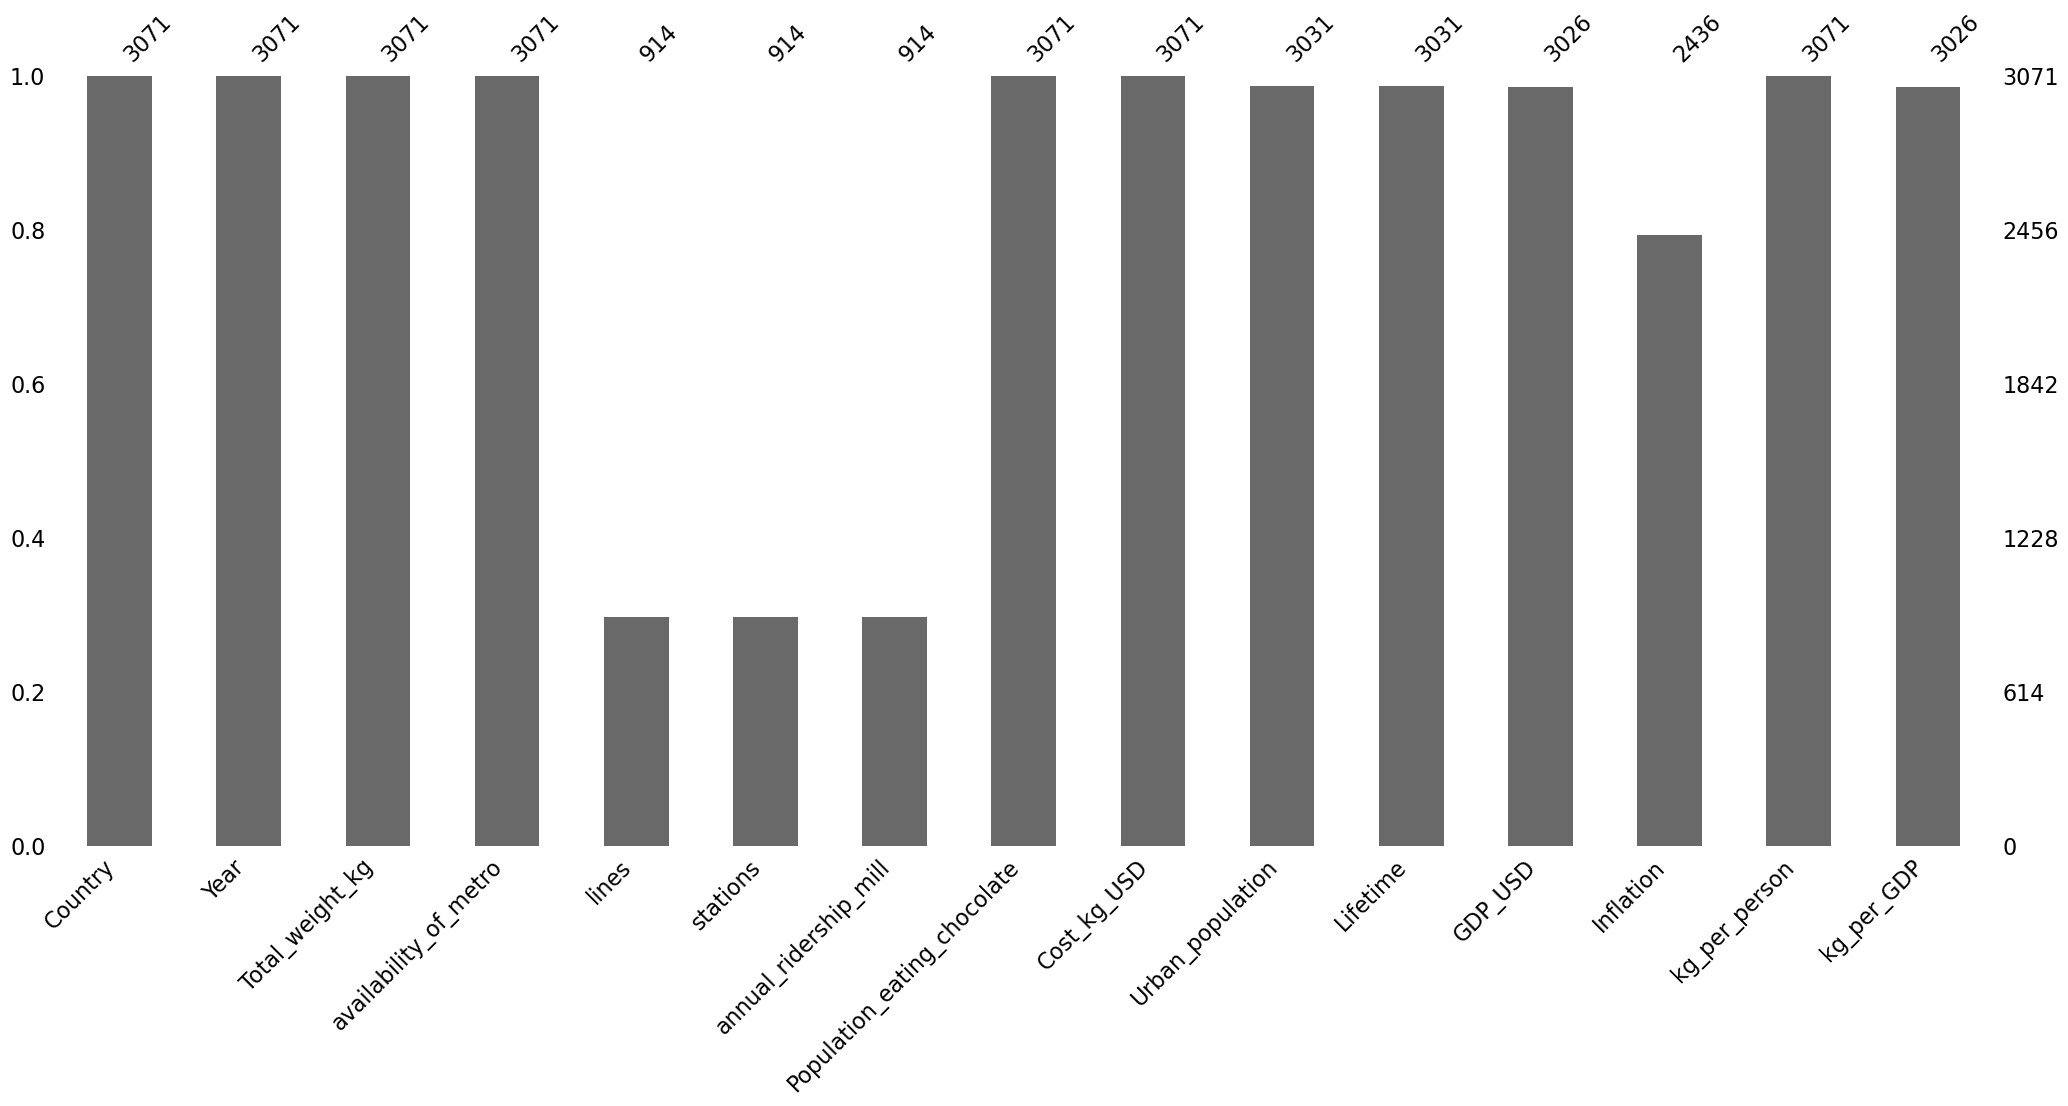

In [3]:
# 1 ЭТАП
# 1.1 Проверка миссингов
msno.bar(df);

In [4]:
# Заполнение миссингов
# 1.2 Заполнение миссингов в 'Total_weight_kg' на средние значения по странам
country_means = df.groupby('Country')['Total_weight_kg'].transform('mean')
df['Total_weight_kg'] = df['Total_weight_kg'].mask((df['Total_weight_kg'].isna()), country_means)
# 1.3 Заполнение миссингов в 'Inflation' на средние значения по году
inflation_means_by_year = df.groupby('Year')['Inflation'].transform('mean')
df['Inflation'] = df['Inflation'].fillna(inflation_means_by_year)
# 1.4 Заполнение миссингов в 'Urban_population' на средние значения по году
Urban_population_means_by_year = df.groupby('Year')['Urban_population'].transform('mean')
df['Urban_population'] = df['Urban_population'].fillna(Urban_population_means_by_year)
# 1.5 Заполнение миссингов в 'Lifetime' на средние значения по году
Lifetime_means_by_year = df.groupby('Year')['Lifetime'].transform('mean')
df['Lifetime'] = df['Lifetime'].fillna(Lifetime_means_by_year)
# 1.6 Заполнение миссингов GDP_USD
replacement_GDP = {
    'Faroe Islands': ('Denmark', 0.015),
    'Mayotte': ('Comoros', 2),
    'Netherlands Antilles': ('Netherlands', 0.005),
    'Sudan': ('Egypt', 0.3),
    'Wallis and Futuna Islands': ('New Zealand', 0.001)}
for country, (source_country, multiplier) in replacement_GDP.items():
    missing_mask = (df['Country'] == country) & (df['GDP_USD'].isna())
    years = df.loc[missing_mask, 'Year'].unique()
    for year in years:
        source_value = df.loc[(df['Country'] == source_country) &  (df['Year'] == year), 'GDP_USD'].values
        if len(source_value) > 0:
            replacement_value = np.float32(source_value[0] * multiplier)
            df.loc[(df['Country'] == country) & 
                  (df['Year'] == year), 'GDP_USD'] = replacement_value
# 1.7 Заполнение миссингов в kg_per_person: Total_weight_kg / Population_eating_chocolate
mask_kg_per_person = df['kg_per_person'].isna()
df.loc[mask_kg_per_person, 'kg_per_person'] = (
    df.loc[mask_kg_per_person, 'Total_weight_kg'] / 
    df.loc[mask_kg_per_person, 'Population_eating_chocolate']).astype('float32')
# 1.8 Заполнение миссингов в kg_per_GDP: Total_weight_kg / GDP_USD
mask_kg_per_gdp = df['kg_per_GDP'].isna()
df.loc[mask_kg_per_gdp, 'kg_per_GDP'] = (
    df.loc[mask_kg_per_gdp, 'Total_weight_kg'] / 
    df.loc[mask_kg_per_gdp, 'GDP_USD']).astype('float32')

In [5]:
df.isna().sum()

Country                           0
Year                              0
Total_weight_kg                   0
availability_of_metro             0
lines                          2157
stations                       2157
annual_ridership_mill          2157
Population_eating_chocolate       0
Cost_kg_USD                       0
Urban_population                  0
Lifetime                          0
GDP_USD                           0
Inflation                         0
kg_per_person                     0
kg_per_GDP                        0
dtype: int64

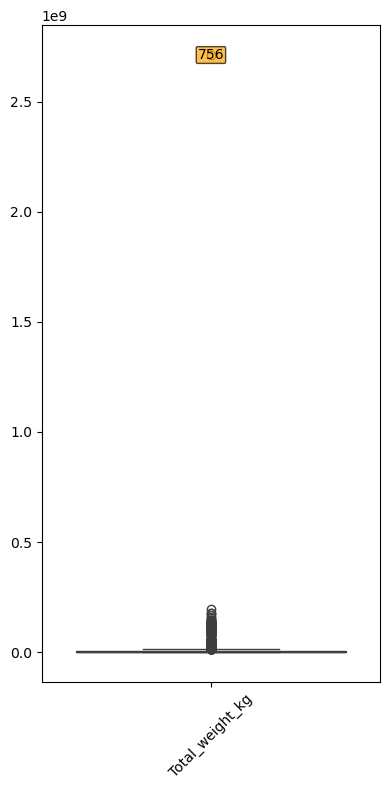

In [6]:
# 2 ЭТАП
# 2.1 Проверка и удаление выбросов по столбцам
numeric_cols = ['Total_weight_kg']
plt.figure(figsize=(4, 8))
ax = sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)
# Функция для поиска выбросов методом z-score
def find_outliers_zscore(data, column, threshold=4):
    z_scores = np.abs(stats.zscore(data[column]))
    return data.loc[z_scores > threshold].index.tolist()
for column in numeric_cols:
    outliers_idx = find_outliers_zscore(df, column, threshold=4)
    col_pos = numeric_cols.index(column)
    for idx in outliers_idx:
        value = df.at[idx, column]
        ax.text(col_pos, value, f'{idx}', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='orange', alpha=0.7),
                fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [7]:
# 2.1 Удаление строк с выбросами по столбцу 'Total_weight_kg'
outliers_indices = find_outliers_zscore(df, 'Total_weight_kg', threshold=4)
print(f"Найдено выбросов в 'Total_weight_kg': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
dfW = df.drop(index=outliers_indices).copy()

Найдено выбросов в 'Total_weight_kg': 1
Индексы строк с выбросами: [756]


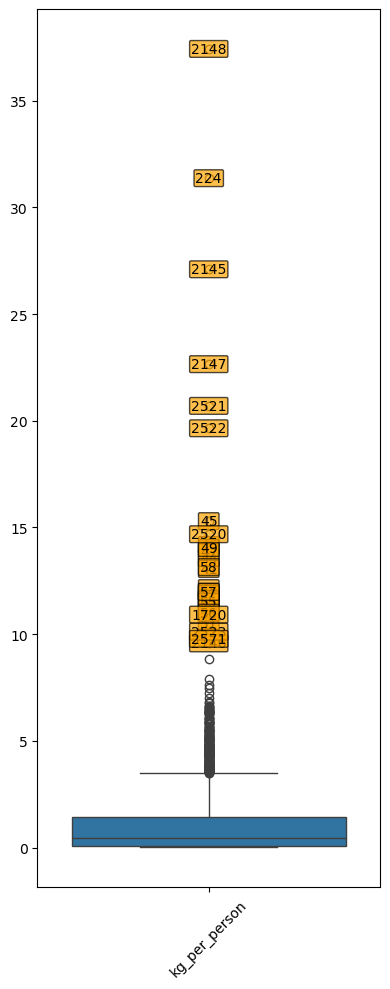

In [8]:
# 2.2 Проверка и удаление выбросов по столбцу 'kg_per_person'
numeric_cols = ['kg_per_person']
plt.figure(figsize=(4, 10))
ax = sns.boxplot(data=dfW[numeric_cols])
plt.xticks(rotation=45)
def find_outliers_zscore(data, column, threshold=4):
    z_scores = np.abs(stats.zscore(data[column]))
    return data.loc[z_scores > threshold].index.tolist()
for column in numeric_cols:
    outliers_idx = find_outliers_zscore(dfW, column, threshold=4)
    col_pos = numeric_cols.index(column)
    for idx in outliers_idx:
        value = dfW.at[idx, column]
        ax.text(col_pos, value, f'{idx}', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='orange', alpha=0.7),
                fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [9]:
# 2.2 Удаление строк с выбросами по столбцу 'kg_per_person'
outliers_indices = find_outliers_zscore(dfW, 'kg_per_person', threshold=4)
print(f"Найдено выбросов в 'kg_per_person': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
dfW1 = dfW.drop(index=outliers_indices).copy()

Найдено выбросов в 'kg_per_person': 29
Индексы строк с выбросами: [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 224, 1720, 2145, 2146, 2147, 2148, 2520, 2521, 2522, 2523, 2571]


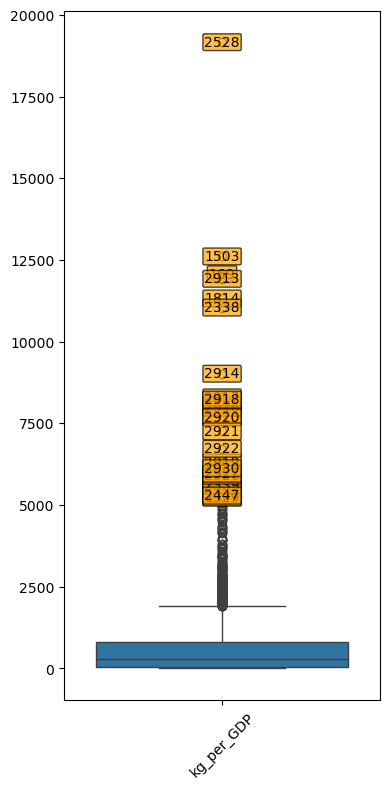

In [10]:
# 2.3 Повторная проверка и удаление выбросов
numeric_cols = ['kg_per_GDP']
plt.figure(figsize=(4, 8))
ax = sns.boxplot(data=dfW1[numeric_cols])
plt.xticks(rotation=45)
def find_outliers_zscore(data, column, threshold=4):
    z_scores = np.abs(stats.zscore(data[column]))
    return data.loc[z_scores > threshold].index.tolist()
for column in numeric_cols:
    outliers_idx = find_outliers_zscore(dfW1, column, threshold=4)
    col_pos = numeric_cols.index(column)
    for idx in outliers_idx:
        value = dfW1.at[idx, column]
        ax.text(col_pos, value, f'{idx}', 
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='orange', alpha=0.7),
                fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [11]:
# 2.3 Удаление строк с выбросами с выбросами по столбцу 'kg_per_GDP'
outliers_indices = find_outliers_zscore(dfW1, 'kg_per_GDP', threshold=4)
print(f"Найдено выбросов в 'kg_per_GDP': {len(outliers_indices)}")
print("Индексы строк с выбросами:", sorted(outliers_indices))
dfW2 = dfW1.drop(index=outliers_indices).copy()

Найдено выбросов в 'kg_per_GDP': 33
Индексы строк с выбросами: [169, 352, 595, 1035, 1036, 1038, 1039, 1124, 1125, 1128, 1129, 1329, 1503, 1537, 1814, 2338, 2339, 2447, 2528, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2926, 2927, 2930]


In [12]:
dfW2

,Country,Year,Total_weight_kg,availability_of_metro,lines,stations,annual_ridership_mill,Population_eating_chocolate,Cost_kg_USD,Urban_population,Lifetime,GDP_USD,Inflation,kg_per_person,kg_per_GDP
0,Albania,1996,273411.0,No,NaN,NaN,NaN,1557925.0,6.214,39.473000,74.112999,985.820007,12.725478,0.1755,277.343689
1,Albania,1997,222897.0,No,NaN,NaN,NaN,1550237.0,6.214,40.035000,73.383003,688.820007,33.180275,0.1438,323.592499
2,Albania,1998,243309.0,No,NaN,NaN,NaN,1540864.0,6.214,40.601002,74.357002,795.880005,20.642859,0.1579,305.710693
3,Albania,1999,420293.0,No,NaN,NaN,NaN,1530526.0,6.214,41.168999,74.568001,1010.369995,0.389438,0.2746,415.979309
4,Albania,2000,303615.0,No,NaN,NaN,NaN,1519751.0,6.214,41.741001,74.825996,1101.520020,0.050018,0.1998,275.632812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,Zimbabwe,2012,629857.0,No,NaN,NaN,NaN,4559903.0,8.215,32.834000,55.386002,1238.599976,3.725327,0.1381,508.523285
3067,Zimbabwe,2013,556758.0,No,NaN,NaN,NaN,4624557.0,8.215,32.653999,56.841999,1362.300049,1.634950,0.1204,408.689697
3068,Zimbabwe,2014,576602.0,No,NaN,NaN,NaN,4688428.0,8.215,32.504002,58.105999,1372.209961,-0.197785,0.1230,420.199493
3069,Zimbabwe,2015,486762.0,No,NaN,NaN,NaN,4751674.0,8.215,32.384998,58.988998,1386.420044,-2.430969,0.1024,351.092712


In [13]:
# Сохранение результата
output_file = "Results_dfW2.csv"
dfW2.to_csv(output_file, index=False)

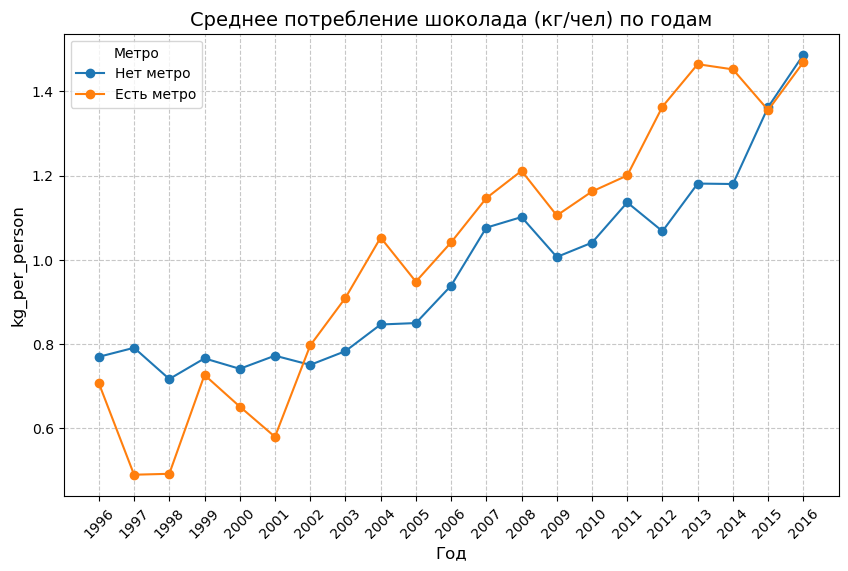

In [14]:
# 2.4 Визуализация среднего потребления шоколада (кг/чел) по годам
result = dfW2.groupby(['Year', 'availability_of_metro'])['kg_per_person'].mean().unstack()
result.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Среднее потребление шоколада (кг/чел) по годам', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('kg_per_person', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Метро', labels=['Нет метро', 'Есть метро'])
years = result.index
plt.xticks(years, labels=[int(year) for year in years], rotation=45)
plt.show()

In [15]:
# 3 ЭТАП
# Формируем нулевую гипотезу (H0): В странах с метро уровень потребления шоколада среди населения такой же как и без метро.
# 3.1.1 Сравнение средних 'kg_per_person' между группами с метро
with_metro = dfW2[dfW2['availability_of_metro'] == "Yes"]['kg_per_person']
without_metro = dfW2[dfW2['availability_of_metro'] == "No"]['kg_per_person']
t_statistic, p_value = stats.ttest_ind(with_metro, without_metro)
f"results_ttest: T-статистика: {t_statistic:.4f}, P-значение: {p_value:.4f}"

'results_ttest: T-статистика: 1.3360, P-значение: 0.1816'

Описательная статистика:
Страны с метро: медиана - 0.61 кг/чел
Страны без метро: медиана: - 0.34 кг/чел

Результаты теста Манна-Уитни:
Статистика: 1083137.50
p-value: 0.00000

Отвергаем нулевую гипотезу. Потребление шоколада значимо выше в странах с метро (p < 0.05).


Text(0, 0.5, 'кг/человека')

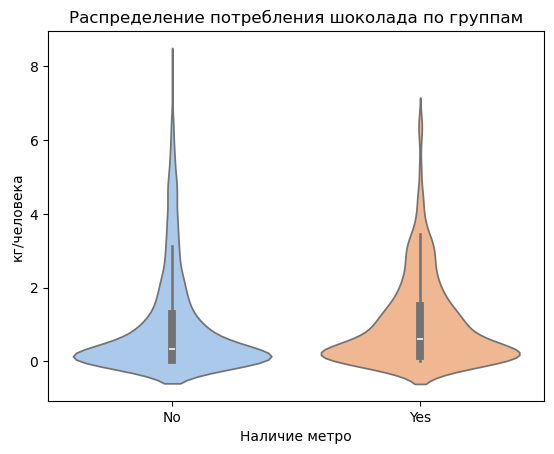

In [16]:
# 3.1.2 Непараметрический тест Манна-Уитни
# Подготовка данных
with_metro = dfW2[dfW2['availability_of_metro'] == 'Yes']['kg_per_person'].dropna()
without_metro = dfW2[dfW2['availability_of_metro'] == 'No']['kg_per_person'].dropna()
# Описательная статистика
print("Описательная статистика:")
print(f"Страны с метро: медиана - {np.median(with_metro):.2f} кг/чел")
print(f"Страны без метро: медиана: - {np.median(without_metro):.2f} кг/чел")
# Тест Манна-Уитни
stat, p = mannwhitneyu(with_metro, without_metro, alternative='greater')
print("\nРезультаты теста Манна-Уитни:")
print(f"Статистика: {stat:.2f}")
print(f"p-value: {p:.5f}")
# Интерпретация
alpha = 0.05
if p < alpha:
    print("\nОтвергаем нулевую гипотезу. Потребление шоколада значимо выше в странах с метро (p < 0.05).")
else:
    print("\nНе отвергаем нулевую гипотезу. Потребление шоколада не отличается значимо.")
sns.violinplot(x='availability_of_metro', y='kg_per_person', data=dfW2, hue='availability_of_metro', palette='pastel', legend=False)
plt.title('Распределение потребления шоколада по группам')
plt.xlabel('Наличие метро')
plt.ylabel('кг/человека')

In [17]:
# 3.1.3 Cтандартизированная разница средних (Cohen’s d)
with_metro = dfW2[dfW2['availability_of_metro'] == 'Yes']['kg_per_person'].dropna()
without_metro = dfW2[dfW2['availability_of_metro'] == 'No']['kg_per_person'].dropna()
mean_yes, mean_no = with_metro.mean(), without_metro.mean()
std_pooled = np.sqrt((with_metro.std()**2 + without_metro.std()**2) / 2)
cohen_d = (mean_yes - mean_no) / std_pooled
print(f"Cohen’s d: {cohen_d:.3f}")

Cohen’s d: 0.055


In [18]:
# Формируем нулевую гипотезу (H0): В странах с метро шоколадоёмкость экономики такая же как и без метро.
# 3.2.1 Сравнение средних 'kg_per_GDP' между группами с метро
with_metro = dfW2[dfW2['availability_of_metro'] == "Yes"]['kg_per_GDP']
without_metro = dfW2[dfW2['availability_of_metro'] == "No"]['kg_per_GDP']
t_statistic, p_value = stats.ttest_ind(with_metro, without_metro)
f"results_ttest: T-статистика: {t_statistic:.4f}, P-значение: {p_value:.4f}"

'results_ttest: T-статистика: 23.8247, P-значение: 0.0000'

Описательная статистика:
Страны с метро: медиана шоколадоёмкости - 724.68 кг/USD
Страны без метро: медиана шоколадоёмкости - 163.30 кг/USD

Результаты теста Манна-Уитни:
Статистика: 1519378.00
p-value: 0.00000

Отвергаем нулевую гипотезу. Шоколадоёмкость значимо выше в странах с метро (p < 0.05).


Text(0, 0.5, 'кг/USD')

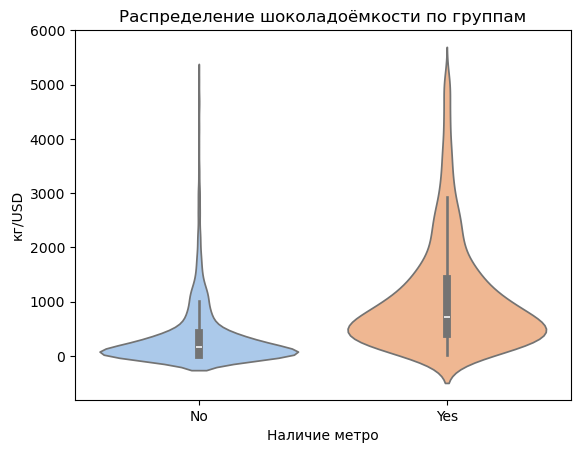

In [19]:
# 3.2.2 Непараметрический тест Манна-Уитни
# Подготовка данных
with_metro = dfW2[dfW2['availability_of_metro'] == 'Yes']['kg_per_GDP'].dropna()
without_metro = dfW2[dfW2['availability_of_metro'] == 'No']['kg_per_GDP'].dropna()
# Описательная статистика
print("Описательная статистика:")
print(f"Страны с метро: медиана шоколадоёмкости - {np.median(with_metro):.2f} кг/USD")
print(f"Страны без метро: медиана шоколадоёмкости - {np.median(without_metro):.2f} кг/USD")
# Тест Манна-Уитни
stat, p = mannwhitneyu(with_metro, without_metro, alternative='greater')
print("\nРезультаты теста Манна-Уитни:")
print(f"Статистика: {stat:.2f}")
print(f"p-value: {p:.5f}")
# Интерпретация
alpha = 0.05
if p < alpha:
    print("\nОтвергаем нулевую гипотезу. Шоколадоёмкость значимо выше в странах с метро (p < 0.05).")
else:
    print("\nНе отвергаем нулевую гипотезу. Шоколадоёмкость не отличается значимо.")
sns.violinplot(x='availability_of_metro', y='kg_per_GDP', data=dfW2, hue='availability_of_metro', palette='pastel', legend=False)
plt.title('Распределение шоколадоёмкости по группам')
plt.xlabel('Наличие метро')
plt.ylabel('кг/USD')

In [20]:
# 3.2.3 Cтандартизированная разница средних (Cohen’s d)
with_metro = dfW2[dfW2['availability_of_metro'] == 'Yes']['kg_per_GDP'].dropna()
without_metro = dfW2[dfW2['availability_of_metro'] == 'No']['kg_per_GDP'].dropna()
mean_yes, mean_no = with_metro.mean(), without_metro.mean()
std_pooled = np.sqrt((with_metro.std()**2 + without_metro.std()**2) / 2)
cohen_d = (mean_yes - mean_no) / std_pooled
print(f"Cohen’s d: {cohen_d:.3f}")

Cohen’s d: 0.855


In [21]:
# 4 ЭТАП
# КОРРЕЛЯЦИОННЫЙ И РЕГРЕСИОННЫЙ АНАЛИЗЫ
# Принимаем outcome - kg_per_GDP; predictors - availability_of_metro, Urban_population, Cost_kg_USD, GDP_USD, kg_per_person

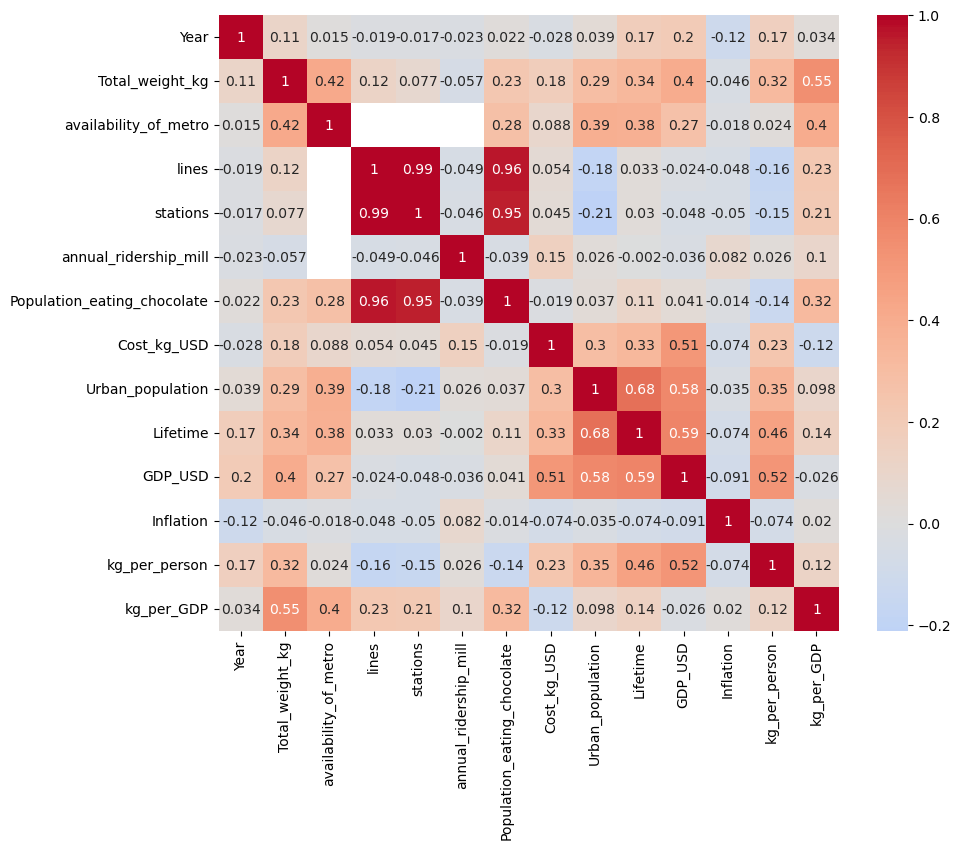

In [22]:
# 4.1 Подготовка данных
dfK1 = dfW2[['Year','Total_weight_kg', 'availability_of_metro', 'lines',
       'stations', 'annual_ridership_mill', 'Population_eating_chocolate',
       'Cost_kg_USD', 'Urban_population', 'Lifetime', 'GDP_USD', 'Inflation',
       'kg_per_person', 'kg_per_GDP']].copy()
dfK1['availability_of_metro'] = dfK1['availability_of_metro'].map({'Yes': 1, 'No': 0})
# 4.2 Корреляционный анализ
correlation_matrix = dfK1.corr().round(3)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

In [23]:
correlation_matrix

,Year,Total_weight_kg,availability_of_metro,lines,stations,annual_ridership_mill,Population_eating_chocolate,Cost_kg_USD,Urban_population,Lifetime,GDP_USD,Inflation,kg_per_person,kg_per_GDP
Year,1.000,0.114,0.015,-0.019,-0.017,-0.023,0.022,-0.028,0.039,0.175,0.199,-0.116,0.166,0.034
Total_weight_kg,0.114,1.000,0.422,0.120,0.077,-0.057,0.231,0.180,0.290,0.336,0.403,-0.046,0.315,0.549
availability_of_metro,0.015,0.422,1.000,NaN,NaN,NaN,0.277,0.088,0.386,0.378,0.269,-0.018,0.024,0.399
lines,-0.019,0.120,NaN,1.000,0.992,-0.049,0.958,0.054,-0.181,0.033,-0.024,-0.048,-0.161,0.228
stations,-0.017,0.077,NaN,0.992,1.000,-0.046,0.948,0.045,-0.212,0.030,-0.048,-0.050,-0.150,0.213
annual_ridership_mill,-0.023,-0.057,NaN,-0.049,-0.046,1.000,-0.039,0.152,0.026,-0.002,-0.036,0.082,0.026,0.100
Population_eating_chocolate,0.022,0.231,0.277,0.958,0.948,-0.039,1.000,-0.019,0.037,0.108,0.041,-0.014,-0.136,0.316
Cost_kg_USD,-0.028,0.180,0.088,0.054,0.045,0.152,-0.019,1.000,0.299,0.329,0.512,-0.074,0.234,-0.120
Urban_population,0.039,0.290,0.386,-0.181,-0.212,0.026,0.037,0.299,1.000,0.680,0.581,-0.035,0.347,0.098
Lifetime,0.175,0.336,0.378,0.033,0.030,-0.002,0.108,0.329,0.680,1.000,0.593,-0.074,0.459,0.144


In [24]:
# 4.3 Модель
dfK1['log_kg_per_GDP'] = np.log(dfK1['kg_per_GDP'])
dfK1['log_Cost_kg_USD'] = np.log(dfK1['Cost_kg_USD'])
dfK1['log_GDP_USD'] = np.log(dfK1['GDP_USD'])
dfK1['log_kg_per_person'] = np.log(dfK1['kg_per_person'])
model = smf.ols('log_kg_per_GDP ~ availability_of_metro + Urban_population + log_Cost_kg_USD + log_GDP_USD + log_kg_per_person',data=dfK1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_kg_per_GDP   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     518.8
Date:                Fri, 25 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:27:29   Log-Likelihood:                -5587.3
No. Observations:                3008   AIC:                         1.119e+04
Df Residuals:                    3002   BIC:                         1.122e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                14.5510      0.294     49.563      0.000      13.975      15.127
availability_of_metro     2.3964      0.069     34.769      0.000       2.261       2.532
Urban_population          0.0213      0.002     10.839      0.000       0.017       0.025
log_Cost_kg_USD          -1.2739      0.106    -12.049      0.000      -1.481      -1.067
log_GDP_USD              -0.9227      0.032    -28.534      0.000      -0.986      -0.859
log_kg_per_person         0.6193      0.020     31.265      0.000       0.580       0.658
==============================================================================
Omnibus:                      160.390   Durbin-Watson:                   0.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.460
Skew:                          -0.480   Prob(JB):                     2.46e-50
Kurtosis:                       3.950   Cond. No.                         675.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# 4.4 Проверка нормальности распределения
print("\nПроверка нормальности распределения зависимой переменной:")
shapiro_test = stats.shapiro(dfK1['log_kg_per_GDP'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}')
print(f'p-value: {shapiro_test.pvalue:.10f}')


Проверка нормальности распределения зависимой переменной:
Shapiro-Wilk Test Statistic: 0.9179
p-value: 0.0000000000



Анализ распределения:


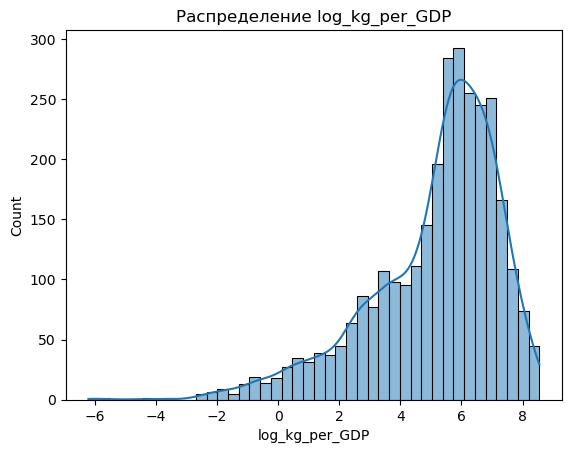

Коэффициент асимметрии: -1.1575510501861572


In [26]:
# 4.5 Визуализация распределения и асимметрии
print("\nАнализ распределения:")
sns.histplot(data=dfK1, x="log_kg_per_GDP", kde=True)
plt.title('Распределение log_kg_per_GDP')
plt.show()
skewness = dfK1['log_kg_per_GDP'].skew()
print(f'Коэффициент асимметрии: {skewness}')

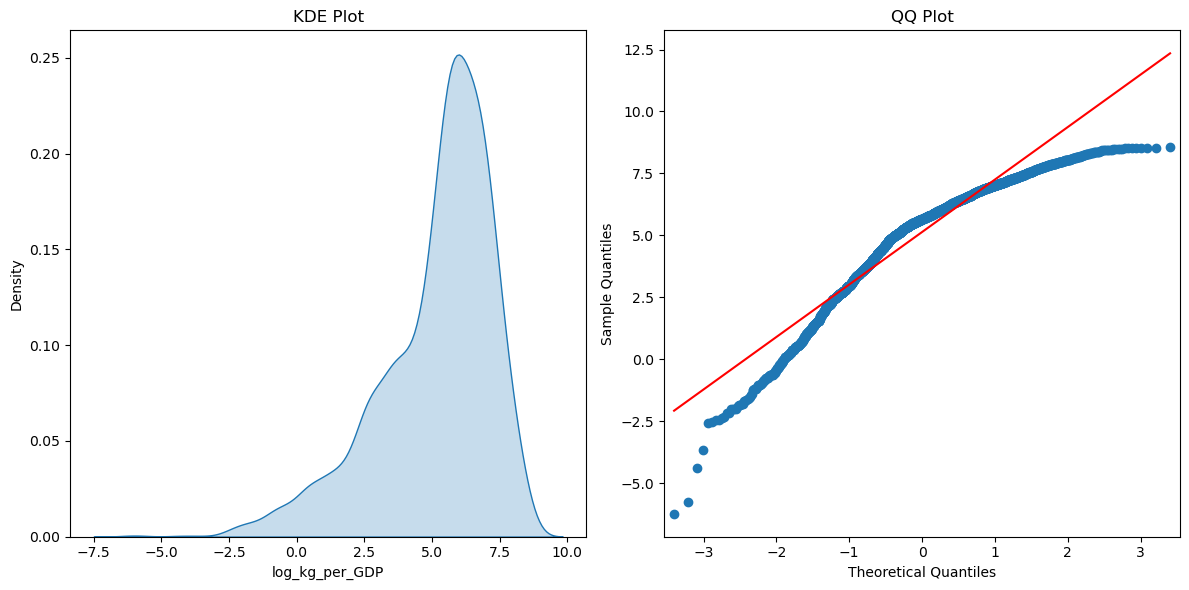

In [27]:
# 5 ЭТАП
# ДИСПЕРСИОННЫЙ АНАЛИЗ
# 5.1 Визуализация распределения Lifetime с использованием KDE Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(dfK1['log_kg_per_GDP'], fill=True)
plt.title('KDE Plot')
# С использованием QQ-Plot
plt.subplot(1, 2, 2)
sm.qqplot(dfK1['log_kg_per_GDP'], line='s', ax=plt.gca())
plt.title('QQ Plot')
plt.tight_layout()

In [28]:
# 5.2 Робастная линейная регрессия
model = smf.rlm('log_kg_per_GDP ~ availability_of_metro + Urban_population + log_Cost_kg_USD + log_GDP_USD + log_kg_per_person', data=dfK1, 
                M=sm.robust.norms.HuberT()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:         log_kg_per_GDP   No. Observations:                 3008
Model:                            RLM   Df Residuals:                     3002
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 25 Jul 2025                                         
Time:                        11:27:30                                         
No. Iterations:                    25                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                14.4090      0.288     50.093      0.000      13.845      14.973
availability_of_metro     2.2215      0.068     32.898      0.000       2.089       2.354
Urban_population          0.0203      0.002     10.558      0.000       0.017       0.024
log_Cost_kg_USD          -1.3477      0.104    -13.011      0.000      -1.551      -1.145
log_GDP_USD              -0.8691      0.032    -27.430      0.000      -0.931      -0.807
log_kg_per_person         0.5911      0.019     30.460      0.000       0.553       0.629
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

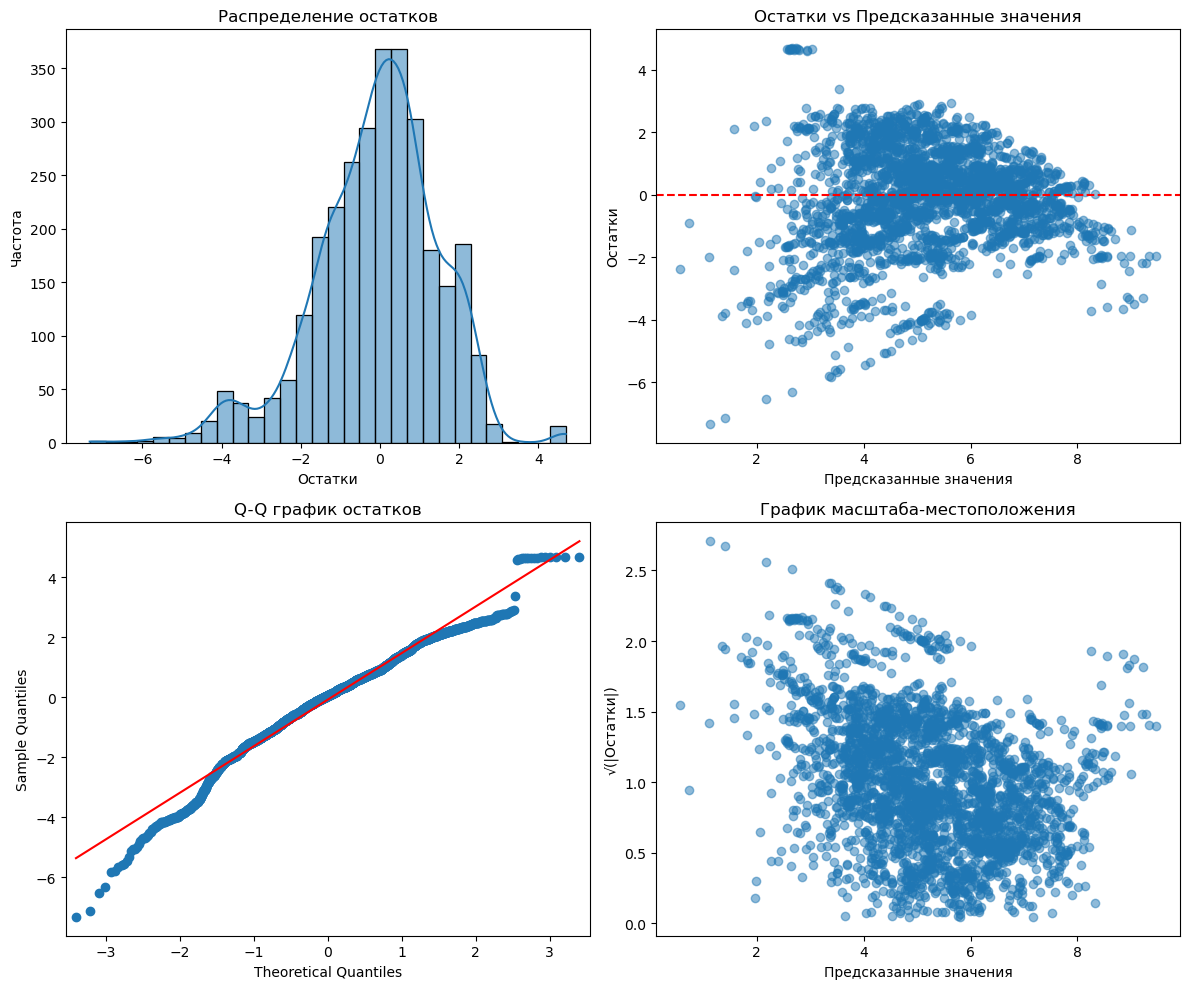

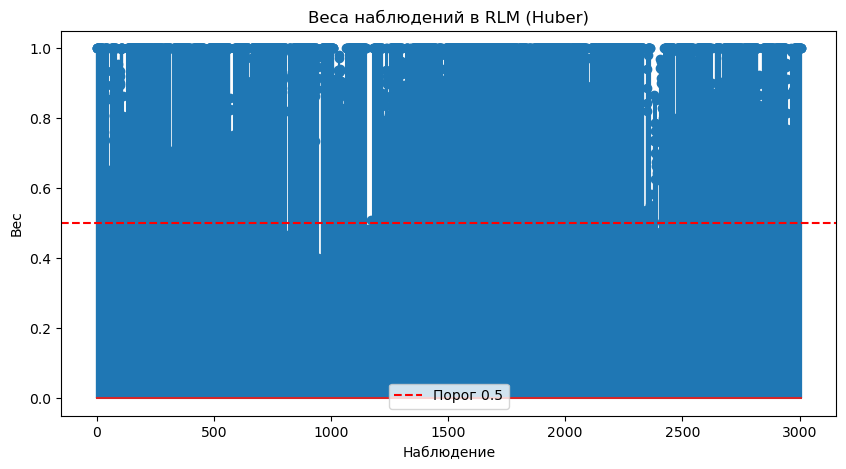


Найдено потенциальных выбросов: 113
Индексы выбросов: [ 399  675  809  810  811  812  813  814  815  816  817  818  819  820
  821  945  946  947  948  949  950  951  952  953  954  955  956  957
  958  959  960 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160
 1161 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171 1173 1174 1175
 1176 1177 1178 1179 1180 1224 1228 1479 1480 1481 1482 1483 1484 1485
 1486 1487 1836 1837 1838 1839 1840 1841 1842 1843 1844 2105 2106 2107
 2108 2334 2340 2341 2342 2343 2364 2371 2372 2373 2374 2375 2376 2394
 2395 2396 2397 2398 2399 2400 2401 2402 2403 2404 2755 2756 2757 2821
 2962]

Breusch-Pagan тест на гетероскедастичность:
LM-статистика: 361.597, p-value: 0.000
Обнаружена гетероскедастичность (p < 0.05)

Дополнительная диагностика:
Медианное абсолютное отклонение остатков: 0.918
Максимальный остаток: 4.687, Минимальный: -7.329
Доля наблюдений с весом < 0.5: 3.76%


In [29]:
# 5.3 Анализ остатков робастной линейной регрессии
# 1. Графики остатков
residuals = model.resid
fitted = model.fittedvalues
plt.figure(figsize=(12, 10))
# 1.1. Распределение остатков
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
# 1.2. Остатки vs предсказанные значения
plt.subplot(2, 2, 2)
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Остатки vs Предсказанные значения')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
# 1.3. Q-Q график
plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q график остатков')
# 1.4. График масштаба-местоположения
plt.subplot(2, 2, 4)
residuals_abs_sqrt = np.sqrt(np.abs(residuals))
plt.scatter(fitted, residuals_abs_sqrt, alpha=0.5)
plt.title('График масштаба-местоположения')
plt.xlabel('Предсказанные значения')
plt.ylabel('√(|Остатки|)')
plt.tight_layout()
plt.show()
# 2. Анализ выбросов для RLM (используем веса модели)
plt.figure(figsize=(10, 5))
weights = model.weights
plt.stem(weights)
plt.title('Веса наблюдений в RLM (Huber)')
plt.xlabel('Наблюдение')
plt.ylabel('Вес')
plt.axhline(y=0.5, color='r', linestyle='--', label='Порог 0.5')
plt.legend()
plt.show()
# Наблюдения с низкими весами (менее 0.5) можно считать выбросами
outliers = np.where(weights < 0.5)[0]
print(f"\nНайдено потенциальных выбросов: {len(outliers)}")
if len(outliers) > 0:
    print("Индексы выбросов:", outliers)
# 3. Тест на гетероскедастичность
try:
    bp_test = het_breuschpagan(residuals, model.model.exog)
    print(f"\nBreusch-Pagan тест на гетероскедастичность:")
    print(f"LM-статистика: {bp_test[0]:.3f}, p-value: {bp_test[1]:.3f}")
    if bp_test[1] < 0.05:
        print("Обнаружена гетероскедастичность (p < 0.05)")
    else:
        print("Гетероскедастичность не обнаружена (p >= 0.05)")
except Exception as e:
    print(f"\nНе удалось выполнить тест на гетероскедастичность: {str(e)}")
# 4. Дополнительная диагностика
print("\nДополнительная диагностика:")
print(f"Медианное абсолютное отклонение остатков: {np.median(np.abs(residuals)):.3f}")
print(f"Максимальный остаток: {np.max(residuals):.3f}, Минимальный: {np.min(residuals):.3f}")
print(f"Доля наблюдений с весом < 0.5: {len(outliers)/len(weights):.2%}")

# 5.4 Обобщённая линейная модель (GLM) с гамма-распределением
model1 = smf.glm('log_kg_per_GDP ~ availability_of_metro + Urban_population + log_Cost_kg_USD + log_GDP_USD + log_kg_per_person',data=dfK1,
    family=sm.families.Gamma(link=sm.families.links.Log())).fit(maxiter=100)
model1.summary()

# 5.5 Получаем остатки и предсказанные значения
residuals = model1.resid_pearson
fitted_values = model1.fittedvalues

# 1. График распределения остатков
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')
plt.xlabel('Пирсоновские остатки')
# 2. Q-Q plot для проверки нормальности
plt.subplot(2, 2, 2)
qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q график остатков')
# 3. График остатков vs предсказанные значения
plt.subplot(2, 2, 3)
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Остатки vs Предсказанные значения')
plt.xlabel('Предсказанные значения')
plt.ylabel('Пирсоновские остатки')
# 4. График масштаба-местоположения
plt.subplot(2, 2, 4)
sns.regplot(x=fitted_values, y=np.sqrt(np.abs(residuals)), lowess=True, 
            line_kws={'color': 'red'})
plt.title('График масштаба-местоположения')
plt.xlabel('Предсказанные значения')
plt.ylabel('√(|Стандартизованные остатки|)')
plt.tight_layout()
plt.show()
# Тест на нормальность остатков (для больших выборок)
if len(residuals) < 5000:
    print("\nТест Шапиро-Уилка на нормальность:")
    shapiro_test = stats.shapiro(residuals)
    print(f"Статистика: {shapiro_test[0]:.4f}, p-value: {shapiro_test[1]:.4f}")
else:
    print("\nТест Колмогорова-Смирнова на нормальность:")
    ks_test = stats.kstest(residuals, 'norm')
    print(f"Статистика: {ks_test.statistic:.4f}, p-value: {ks_test.pvalue:.4f}")
# Проверка гомоскедастичности (тест Бройша-Пагана)
print("\nТест Бройша-Пагана на гомоскедастичность:")
try:
    bp_test = het_breuschpagan(residuals, model1.model.exog)
    print(f"LM статистика: {bp_test[0]:.4f}")
    print(f"p-value: {bp_test[1]:.4f}")
    print("H0: гомоскедастичность (p > 0.05 - не отвергаем)")
except ImportError:
    print("Не удалось выполнить тест Бройша-Пагана")

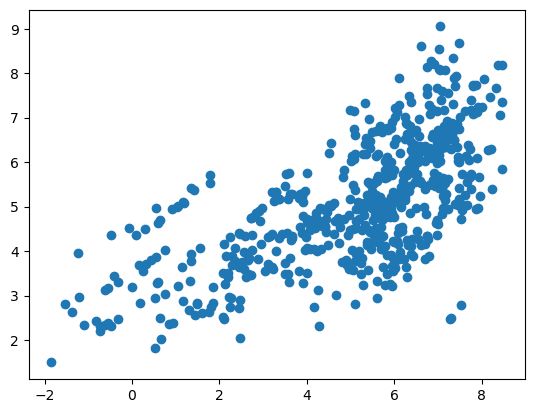

In [44]:
# 6 ЭТАП
# РЕГРЕССИОННАЯ МОДЕЛЬ С ИСПОЛЬЗОВАНИЕМ БИБЛИОТЕКИ Scikit-Learn
# 6.1 Модель линейной регрессии
X = dfK1[['availability_of_metro', 'Urban_population', 'log_Cost_kg_USD', 'log_GDP_USD', 'log_kg_per_person']]
y = dfK1['log_kg_per_GDP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
lm = LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions);

In [45]:
# 6.2 Оценка качества модели
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.2858088892767894
MSE: 2.682416683699497
RMSE: 1.637808500313604


In [33]:
# 6.3 Проверка на мультиколлинеарность (VIF)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data)

                 feature        VIF
0  availability_of_metro   1.710723
1       Urban_population  19.469987
2        log_Cost_kg_USD  44.131101
3            log_GDP_USD  63.316823
4      log_kg_per_person   1.747677


In [34]:
# 6.4 Коэффициенты линейной регрессии
print(lm.coef_)

[ 2.33563481  0.02076356 -1.41023661 -0.88130089  0.61203905]


In [35]:
# 6.5 Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=200)
# Обучение модели
lm = LinearRegression()
lm.fit(X_train, y_train)
# Вывод коэффициентов
print("Коэффициенты:", lm.coef_)
print("Intercept:", lm.intercept_)

Коэффициенты: [ 1.06467402  0.45908114 -0.41213601 -1.34854121  1.23870066]
Intercept: 5.138114638270241


In [36]:
# 6.6 Коэффициент детерминации (R2)
print(f"R² на тесте: {lm.score(X_test, y_test):.3f}")

R² на тесте: 0.445


In [37]:
# 7 ЭТАП
# Машинное обучение
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [38]:
# Загрузка данных
dfM = dfK1.copy()
dfM = dfM.drop(columns=['lines','stations','annual_ridership_mill'])
# Выбор признаков и целевой переменной
features = ['availability_of_metro', 'Urban_population', 'log_Cost_kg_USD', 'log_GDP_USD', 'log_kg_per_person']
target = 'log_kg_per_GDP'
X = dfM[features]
y = dfM[target]
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Масштабирование
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ]),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}
results = []
for name, model in models.items():
    # Обучение
    if name == "Polynomial Regression":
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train, y_train)
    
    # Предсказание
    if name == "Polynomial Regression":
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    # Оценка
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    })
# Результаты
results_dfM = pd.DataFrame(results)
print(results_dfM.sort_values('R2', ascending=False))

                   Model       MAE       MSE        R2
5                XGBoost  0.278163  0.227753  0.946681
3          Random Forest  0.331631  0.310941  0.927206
2          Decision Tree  0.417398  0.885278  0.792750
4      Gradient Boosting  0.766750  1.084545  0.746100
1  Polynomial Regression  1.049282  1.977190  0.537125
0      Linear Regression  1.186990  2.331199  0.454249


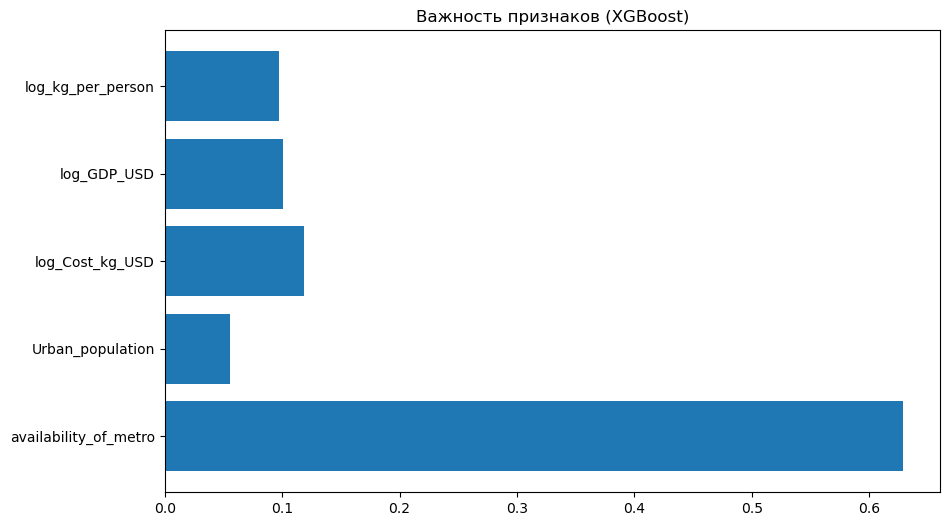

In [40]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
# Важность признаков
plt.figure(figsize=(10, 6))
plt.barh(features, xgb_model.feature_importances_)
plt.title('Важность признаков (XGBoost)')
plt.show()